# USACE topobathy vis with Google Earth Engine

## Computing environment

We'll be using the following Python libraries in this notebook:

In [1]:
%matplotlib widget
import os
import ee
import geemap
import requests
import numpy as np
import matplotlib.pylab as plt
from datetime import datetime
from datetime import timedelta

import geopandas as gpd
import pandas as pd

from utils.oa import dataCollector


## Google Earth Engine Authentication and Initialization
GEE requires you to authenticate your access, so if `ee.Initialize()` does not work you first need to run `ee.Authenticate()`. This gives you a link at which you can use your google account that is associated with GEE to get an authorization code. Copy the authorization code into the input field and hit *enter* to complete authentication. 

In [3]:
try:
    ee.Initialize()
except: 
    ee.Authenticate()
    ee.Initialize()

## Google Earth Engine

Google Earth Engine (GEE) has a large [catalog](https://developers.google.com/earth-engine/datasets) of geospatial raster data, which is ready for analysis in the cloud. It also comes with an online JavaScript code editor.  
<img src="misc/gee_codeeditor.png" alt="gif showing how to get to the data in OpenAltimetry" width="600px">  
But since we all seem to be using python, it would be nice to have these capabilities available in our Jupyter comfort zone...

Thankfully, there is a [python API for GEE](https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api), which we have imported using `import ee` earlier. It doesn't come with an interactive map, but the python package [geemap](https://geemap.org/) has us covered!

## Visualize USACE Topobathy data for Alaska

Data are from https://chs.coast.noaa.gov/htdata/raster2/elevation/ and are stored as an imageCollection [here](https://code.earthengine.google.com/?asset=projects/uaf-coastal-mapping/assets/USACE_AK_DEM)

In [4]:
topobathyColl = ee.ImageCollection('projects/uaf-coastal-mapping/assets/USACE_AK_DEM')
print('Number of DEMs in the collection (all of AK 2019): ', topobathyColl.size().getInfo())

Number of DEMs in the collection (all of AK 2019):  1147


Interactive map to visualize the entire collection. You can zoom around and see where the USACE collected data in western Alaska in 2019.

In [5]:
# initiate our map object with geemap
Map = geemap.Map()
Map.setCenter(-163.0222151036337, 64.58021590637386, zoom=7);
# Add a satellite basemap
Map.add_basemap('SATELLITE') 
Map.layer_opacity(name='Google Satellite', value=0.8)
# Define our visualization parameters for the DEM collection
vis = {
    'min': -4,
    'max': 100,
    'palette': ['440154', '433982', '30678D', '218F8B', '36B677', '8ED542', 'FDE725'], # viridis color palette because I like it :) 
}
Map.addLayer(topobathyColl, vis, 'Topobathy')
Map.add_minimap(zoom=3)

Map

Map(center=[64.58021590637387, -163.0222151036337], controls=(WidgetControl(options=['position', 'transparent_…

#### Select by geographic region of interest

In [6]:
# Specify region of interest from geojson file
fn = 'white_mountain.geojson' # a geojson for white mountain, AK. You could also use a shapefile, etc. 
aoi = geemap.geojson_to_ee(fn)

In [7]:
whiteMtn = topobathyColl.filterBounds(aoi)
print('Number of White Mountain area DEMs: ', whiteMtn.size().getInfo())

# access other collection details with .getInfo (note this can take a while). 

Number of White Mountain area DEMs:  456


In [8]:
# initiate our map object with geemap
Map = geemap.Map()
Map.setCenter(-163.0222151036337, 64.58021590637386, zoom=10);
# Add a satellite basemap
Map.add_basemap('SATELLITE') 
Map.layer_opacity(name='Google Satellite', value=0.8)
# Define our visualization parameters for the DEM collection
vis = {
    'min': -4,
    'max': 130,
    'palette': ['440154', '433982', '30678D', '218F8B', '36B677', '8ED542', 'FDE725'], # viridis color palette because I like it :) 
}
Map.addLayer(whiteMtn, vis, 'Topobathy')
Map.addLayer(aoi, {}, 'White Mountain, AK')
Map.layer_opacity(name='White Mountain, AK', value=0.6)
Map.add_minimap(zoom=3)

Map

Map(center=[64.58021590637387, -163.0222151036337], controls=(WidgetControl(options=['position', 'transparent_…

## Overlay with example IS2 track:
### with OpenAltimetry

In [14]:
# plotting function from OA (from DataVis tutorial) 
def plot_from_oa_url(url,gtx,title='ICESat-2 Data'):
    mydata = dataCollector(oaurl=url,beam=gtx)
    mydata.requestData()
    myplot = mydata.plotData(title=title)
    return (myplot, mydata)

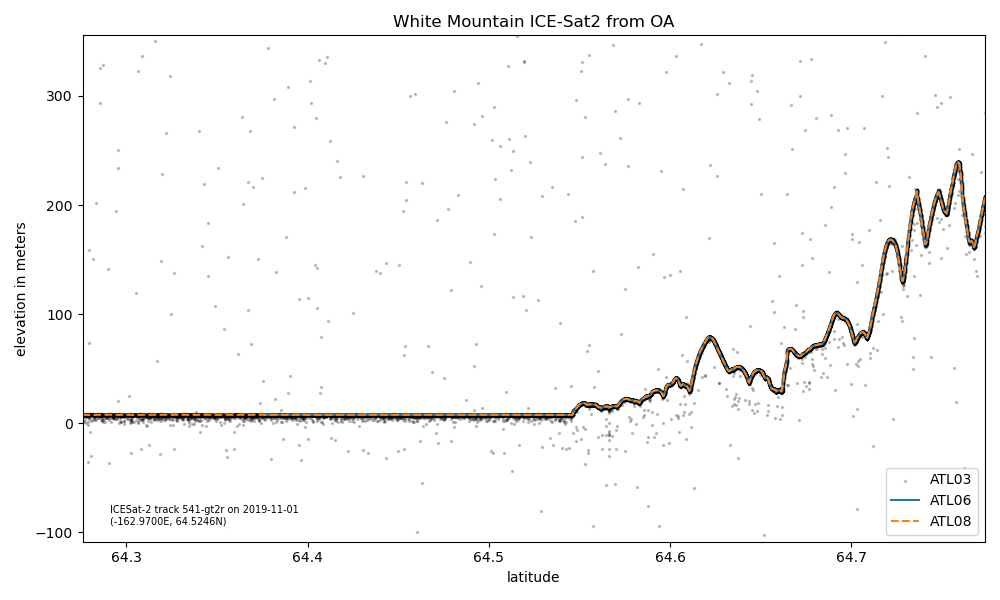

In [10]:
# get data from OpenAltimetry (following DataVis tutorial)
url = 'http://openaltimetry.org/data/api/icesat2/atl06?date=2019-11-01&minx=-163.22047900505012&miny=64.27523261959732&maxx=-162.71950245931393&maxy=64.77401189132661&trackId=541&beamName=gt3r&beamName=gt3l&beamName=gt2r&beamName=gt2l&beamName=gt1r&beamName=gt1l&outputFormat=json'
gtx = 'gt2r'
myplot, mydata = plot_from_oa_url(url=url, gtx=gtx, title='White Mountain ICE-Sat2 from OA')
myplot.savefig('white_mountain_2019-11-01.jpg', dpi=300)

#### Ground Track Stats & Map


In [11]:
def dist_latlon2meters(lat1, lon1, lat2, lon2):
    # returns the distance between two coordinate points - (lon1, lat1) and (lon2, lat2) along the earth's surface in meters.
    R = 6371000
    def deg2rad(deg):
        return deg * (np.pi/180)
    dlat = deg2rad(lat2-lat1)
    dlon = deg2rad(lon2-lon1)
    a = np.sin(dlat/2) * np.sin(dlat/2) + np.cos(deg2rad(lat1)) * np.cos(deg2rad(lat2)) * np.sin(dlon/2) * np.sin(dlon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

lat1, lat2 = mydata.atl08.lat[0], mydata.atl08.lat.iloc[-1]
lon1, lon2 = mydata.atl08.lon[0], mydata.atl08.lon.iloc[-1]

ground_track_length = dist_latlon2meters(lat1, lon1, lat2, lon2)
print('The ground track is about %.1f kilometers long.' % (ground_track_length/1e3))

The ground track is about 55.7 kilometers long.


Now we need to add our ICESat-2 gound track to that map. Let's use the lon/lat coordinates of the ATL08 data product for this.  
We also need to specify which **Coordinate Reference System (CRS)** our data is in. The longitude/latitude system that we are all quite familiar with is referenced by [`EPSG:4326`](https://epsg.io/4326). To add the ground track to the map we need to turn it into an [Earth Engine "Feature Collection"](https://developers.google.com/earth-engine/guides/feature_collections).

In [12]:
ground_track_coordinates = list(zip(mydata.atl08.lon, mydata.atl08.lat))
ground_track_projection = 'EPSG:4326' # <-- this specifies that our data longitude/latitude in degrees [https://epsg.io/4326]
gtx_feature = ee.FeatureCollection(ee.Geometry.LineString(coords=ground_track_coordinates, 
                                      proj=ground_track_projection, 
                                      geodesic=True))
# gtx_feature # check that it is a feature collection for GEE

In [13]:
# overlay the track on our map. 
Map.addLayer(gtx_feature, {'color': 'red'}, 'ground track')
Map

Map(bottom=69238.0, center=[64.58021590637387, -163.0222151036337], controls=(WidgetControl(options=['position…

In [ ]:
# to do: 
# get data with sliderule and overlay